In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import * #评估函数

%matplotlib inline 

In [2]:
# 导入人类数据并初步观察
human_seq_data = pd.read_csv('../data/DNA_sequence_classification/human.txt',sep='\t')
print(human_seq_data.head())
print('数据量：',human_seq_data.shape[0])
# 文件原始列名class与关键词冲突，不能通过.获取
print('类别数：',int(len(set(human_seq_data['class']))))

                                            sequence  class
0  ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...      4
2  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
3  ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...      3
4  ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...      3
数据量： 4380
类别数： 7


长度中位数为： 865.0


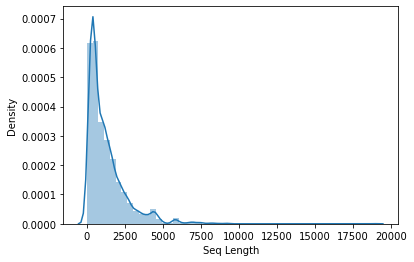

In [3]:
# 探查序列长度分布
seq_len_all = [len(i) for i in human_seq_data.sequence]
sns.distplot(seq_len_all)
plt.xlabel('Seq Length')
plt.ylabel('Density')
plt.savefig('../figure/1-distplot.png',dpi=300,bbox_inches='tight')
print('长度中位数为：',np.median(np.array(seq_len_all)))

In [4]:
# 截取定长序列（对顺序和one-hot编码）
def get_fixed_length_seq(seq_list,len_lim = 865):
    lim_seq = [ ]
    for i in seq_list:
        if len(i) == len_lim:
            lim_seq.append(i)
        elif len(i)<len_lim:
            lim_seq.append(int(np.floor((len_lim - len(i))/2) )*'N'+i+'N'*int(np.ceil((len_lim - len(i))/2)))
        elif len(i)>len_lim:
            diff = len(i) - len_lim
            lim_seq.append(i[int(np.floor(diff/2)):int(-1*(np.ceil(diff/2)))])
    return lim_seq

In [5]:
human_seq_data['lim_seq'] = get_fixed_length_seq(list(human_seq_data.sequence))

In [6]:
# 定义顺序编码函数
def seq_code_dna(dna):
    dna_dict={'A':0.25,'C':0.5,'G':0.75,'T':1.0,'N':0,
    'a':0.25,'c':0.5,'g':0.75,'t':1.0,'n':0}
    return np.array([dna_dict[k] for k in dna])

In [7]:
# 定义one-hot编码函数
def one_hot_dna(dna):
    dna_dict={'A':[1.0,0.,0.,0.],'C':[0.,1.0,0.,0.],'G':[0.,0.,1.0,0.],'T':[0.,0.,0.,1.0],'N':[0.,0.,0.,0.],
    'a':[1.0,0.,0.,0.],'c':[0.,1.0,0.,0.],'g':[0.,0.,1.0,0.],'t':[0.,0.,0.,1.0],'n':[0.,0.,0.,0.]}
    return np.array([dna_dict[k] for k in dna])

In [8]:
# 定义k-mer编码函数
def kmer_dna(dna,k = 5):
    return [dna[i:i+k] for i in range(len(dna) -(k - 1))]

In [9]:
# 对序列进行 one-hot 编码，
human_seq_data['one_hot_seq'] = [one_hot_dna(i) for i in human_seq_data.lim_seq]

#对序列进行顺序编码
human_seq_data['seq_code_seq'] = [seq_code_dna(i) for i in human_seq_data.lim_seq]

#对序列进行k-mer编码
human_seq_data['k_mer_seq'] = [kmer_dna(i) for i in human_seq_data.sequence]
human_seq_data['k_mer_sentence'] = [' '.join(i) for i in human_seq_data.k_mer_seq]

In [10]:
# 调整编码后的列，构建三种编码方式下的数据集
seq_seq_data = pd.DataFrame({'feature':list(human_seq_data['seq_code_seq']),'type':list(human_seq_data['class'])})

# onehot的ACGT四个通道降维成一个
hot_seq_data = pd.DataFrame({'feature':list([i.transpose(1,0).flatten() 
                                             for i in human_seq_data['one_hot_seq']]),'type':list(human_seq_data['class'])})

# 词袋法,限定3个词的组合
from sklearn.feature_extraction.text import TfidfVectorizer
Tf = TfidfVectorizer(ngram_range=(3,3))
k_seq_data = pd.DataFrame({'feature': list(Tf.fit_transform(human_seq_data['k_mer_sentence']).toarray()),
                           'type':list(human_seq_data['class'])})


In [11]:
# 导入随机森林模型
from sklearn.ensemble import RandomForestClassifier

In [12]:
# 模型调用和评估函数
def appl_model(df,model_ = 'RandomForestClassifier'):
    feature = list(df.feature)
    target = list(df.type)
    train_feature, test_feature, train_target, test_target = train_test_split(feature, target, test_size=0.2, random_state=666)
    
    #随机种子666
    model_use = eval(model_)(random_state = 666)
    model = model_use.fit(train_feature,train_target)
    preds = model.predict(test_feature)
    
    
    #真实在前，weighted模式（类间加权重）防止类不平衡的影响
    pre_score = precision_score(test_target, preds,average='weighted')
    
    #混淆矩阵，标准化
    confu_matrix = confusion_matrix(test_target, preds,normalize='true')
    
    
 
    return pre_score,confu_matrix



In [13]:
#顺序编码模型准确率
seq_seq_score,seq_seq_cm = appl_model(seq_seq_data)
print(seq_seq_score)

0.661069405335029


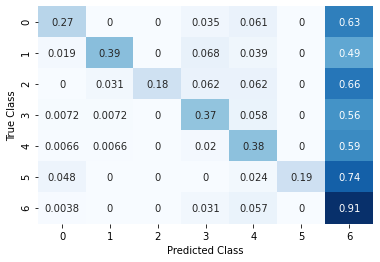

In [15]:
# 绘制混淆矩阵
xtick=['0','1','2','3','4','5','6']
ytick=['0','1','2','3','4','5','6']

sns.heatmap(seq_seq_cm, cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)
#画热力图
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('../figure/1-seq_seq_matrix.png',dpi=300,bbox_inches='tight')
plt.show()


In [16]:
# one-hot编码下的结果
seq_hot_score,seq_hot_cm = appl_model(hot_seq_data)
print(seq_hot_score)

0.6723956044465502


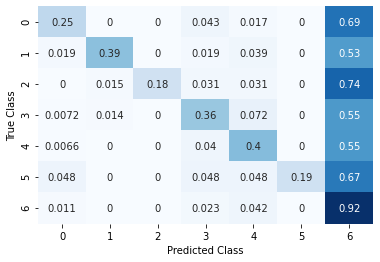

In [17]:
xtick=['0','1','2','3','4','5','6']
ytick=['0','1','2','3','4','5','6']

sns.heatmap(seq_hot_cm, cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('../figure/1-seq_hot_matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [18]:
# k-mer + 词袋法编码下的结果
seq_k_score,seq_k_cm = appl_model(k_seq_data)
print(seq_k_score)

0.8913145587754989


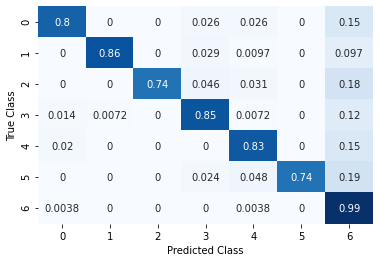

In [19]:
xtick=['0','1','2','3','4','5','6']
ytick=['0','1','2','3','4','5','6']

sns.heatmap(seq_k_cm, cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)
#画热力图,annot=True 代表 在图上显示 对应的值， fmt 属性 代表输出值的格式，cbar=False, 不显示 热力棒
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('../figure/1-seq_k_matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [26]:
# 选定编码方式为k-mer+词袋法
# 构建随机森林模型并进行超参数搜索（随机搜索）
# 
from sklearn.model_selection import RandomizedSearchCV

rf_search = RandomForestClassifier(random_state=666)

# 设定搜索区间 
grid_param_rf={'n_estimators':[int(i) for i in range(10,300,20)],
               'criterion':['gini','entropy'],
               'max_features':['auto','sqrt','log2'],
               'bootstrap':[True,False]}



rand_ser = RandomizedSearchCV(rf_search,grid_param_rf,n_iter=10,random_state=666)

feature = list(k_seq_data.feature)
target = list(k_seq_data.type)
train_feature, test_feature, train_target, test_target = train_test_split(feature, target, test_size=0.2, random_state=666)

rand_ser.fit(train_feature,train_target)

#打印最佳参数组合
print(rand_ser.best_params_)



{'n_estimators': 110, 'max_features': 'sqrt', 'criterion': 'gini', 'bootstrap': False}


In [27]:
# 最佳参数下的模型训练、预测
rf = RandomForestClassifier(n_estimators=110 ,criterion='gini',max_features='sqrt', bootstrap =False ,random_state=666)
rf.fit(train_feature,train_target)
rf_k_pre = rf.predict(test_feature)


In [28]:
# 模型评估 - 准确率和混淆矩阵
print(precision_score(test_target, rf_k_pre,average='weighted'))
final_cm = confusion_matrix(test_target, rf_k_pre,normalize='true')

0.8928139109231933


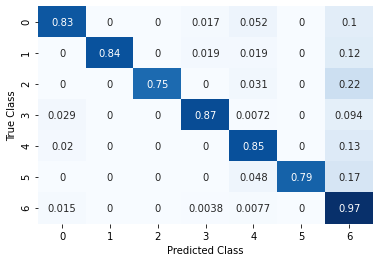

In [29]:
xtick=['0','1','2','3','4','5','6']
ytick=['0','1','2','3','4','5','6']

sns.heatmap(final_cm, cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('../figure/final_k_matrix.png',dpi=300,bbox_inches='tight')